In [1]:
# Standard Imports
from pandas import Series, DataFrame
import pandas as pd
import numpy as np

In [2]:
# Plotting
import matplotlib.pylab as plt
plt.rcParams['font.size'] = 14
import seaborn as sns
%matplotlib inline

In [3]:
# Performance
from time import time

In [4]:
# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
# Helper
from sklearn.cross_validation import train_test_split, KFold
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.grid_search import GridSearchCV

# Preliminaries

In [6]:
# Load in the Data
train = pd.read_csv('input/train2.csv')
test = pd.read_csv('input/test2.csv')

In [7]:
train.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Gender,Port,AgeFill,FareFill
0,1,0,3,1,0,1,0,22,7.2500
1,2,1,1,1,0,0,1,38,71.2833
2,3,1,3,0,0,0,0,26,7.9250
3,4,1,1,1,0,0,0,35,53.1000
4,5,0,3,0,0,1,0,35,8.0500


# Feature engineering
Insights pulled from visualization and exploration notebook

In [8]:
def createNewCol(boolx):
    featx = []
    for i in range(len(boolx)):
        if boolx[i]:
            featx.append(1) 
        else:
            featx.append(0) 

    return featx

In [9]:
# (1) children younger than 18 in the first or second class predominantly survive
bool1 = (train['AgeFill'] < 18) & (train['Pclass'] < 3)
bool1t = (test['AgeFill'] < 18) & (test['Pclass'] < 3)
print(sum(bool1))

train["kidHighClass"] = createNewCol(bool1)
test["kidHighClass"] = createNewCol(bool1t)

35


In [10]:
# (2) mother's with one child in first or second class predominantly survive
bool2 = (train['AgeFill'] > 18) & (train['Parch'] == 1) & (train['Pclass'] < 3) & (train['Gender'] == 0)
bool2t = (test['AgeFill'] > 18) & (test['Parch'] == 1) & (test['Pclass'] < 3) & (test['Gender'] == 0)
print(sum(bool2))

train["momHighClass"] = createNewCol(bool2)
test["momHighClass"] = createNewCol(bool2t)

26


In [11]:
train.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Gender,Port,AgeFill,FareFill,kidHighClass,momHighClass
0,1,0,3,1,0,1,0,22,7.2500,0,0
1,2,1,1,1,0,0,1,38,71.2833,0,0
2,3,1,3,0,0,0,0,26,7.9250,0,0
3,4,1,1,1,0,0,0,35,53.1000,0,0
4,5,0,3,0,0,1,0,35,8.0500,0,0


# Hold-out set

In [8]:
# create hold-out set

features = list(train.columns.values)[2::]
X_train, X_test, y_train, y_test = train_test_split(train[features], train['Survived'])

# Data exploration

In [9]:
X_train.groupby(y_train).mean()

,Pclass,SibSp,Parch,Gender,Port,AgeFill,FareFill
Survived,,,,,,,
0,2.534940,0.563855,0.296386,0.862651,0.325301,29.595181,21.775751
1,1.996016,0.517928,0.474104,0.302789,0.494024,27.829681,48.639427


In [10]:
X_train.groupby(X_train['Pclass']).mean()

,SibSp,Parch,Gender,Port,AgeFill,FareFill
Pclass,,,,,,
1,0.486842,0.375000,0.546053,0.447368,38.634342,86.400274
2,0.390071,0.340426,0.595745,0.134752,30.342766,20.784338
3,0.630027,0.367292,0.715818,0.461126,24.441019,13.892760


# Data visualization 

## for more visualizations see 'Visualization and exploration' notebook

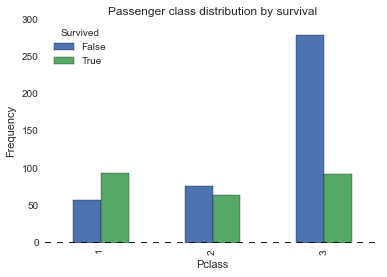

In [11]:
pd.crosstab(X_train.Pclass, y_train.astype(bool)).plot(kind='bar')
plt.title('Passenger class distribution by survival')
plt.xlabel('Pclass')
plt.ylabel('Frequency')

# Feature selection

In [12]:
ch2 = SelectKBest(chi2, k = 4)
X_train2 = ch2.fit_transform(X_train, y_train)
X_train2[0:10]

array([[   3.    ,    1.    ,   21.    ,    7.7333],
       [   3.    ,    1.    ,   25.    ,   15.5   ],
       [   3.    ,    1.    ,   44.    ,   16.1   ],
       [   2.    ,    1.    ,   50.    ,   13.    ],
       [   2.    ,    0.    ,   30.    ,   13.    ],
       [   2.    ,    1.    ,   44.    ,   26.    ],
       [   1.    ,    1.    ,   38.    ,   90.    ],
       [   3.    ,    1.    ,   24.    ,    7.1417],
       [   1.    ,    1.    ,   36.    ,   40.125 ],
       [   1.    ,    0.    ,   21.    ,  262.375 ]])

In [13]:
predictors = list(X_train.columns.values[ch2.get_support()])
print(predictors)

['Pclass', 'Gender', 'AgeFill', 'FareFill']


CV score is  0.777777777778


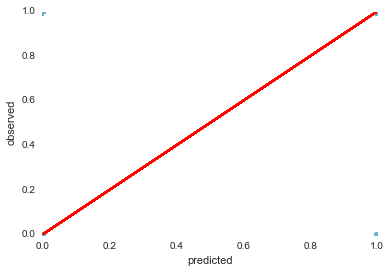

In [29]:
# split the training data into train and test sets

# clf = RandomForestClassifier(n_estimators = 100)
# scores = []

# kf = KFold(len(y_train), n_folds=6)

# for train, test in kf:

#     xtrain, xtest, ytrain, ytest = X_train.iloc()[train], X_train.iloc()[test], y_train.iloc()[train], y_train.iloc()[test]
    
#     b = SelectKBest(chi2, k = 4)
#     b.fit(xtrain, ytrain)
#     xtrain = xtrain.iloc()[:, b.get_support()]
#     xtest = xtest.iloc()[:, b.get_support()]
    
#     clf.fit(xtrain, ytrain)
#     scores.append(clf.score(xtest,ytest))
    
#     yp = clf.predict(xtest)
#     plt.plot(yp, ytest, 'o')
#     plt.plot(ytest, ytest, 'r-')
    
# plt.xlabel("predicted")
# plt.ylabel("observed")

# print("CV score is ", np.mean(scores))
    

# Find random forest hyperparameters
**Goal**: select best number of estimators for random forest

In [14]:
def searchHyperparameters(X, y, param_grid, alg, cval = 10, score = 'accuracy'):
    
    # instantiate the grid
    grid = GridSearchCV(alg, param_grid, cv = cval, scoring = score)
    
    # fit the grid with data
    grid.fit(X, y)
    
    # view the complete results
    print("Best score:", grid.best_score_)
    print("Best parameters:", grid.best_params_)
    print("Best model:", grid.best_estimator_)
    
    # note if SD high, cross-val estimates may not be reliable
    results = grid.grid_scores_
    return results, grid

In [15]:
# Initialize our algorithm
alg = RandomForestClassifier()

In [16]:
# define parameter values to be searched
tree_range = [1, 50, 100, 150, 200]
crit_range = ['gini', 'entropy']
param_grid = dict(n_estimators = tree_range, criterion = crit_range)
print(param_grid)

{'n_estimators': [1, 50, 100, 150, 200], 'criterion': ['gini', 'entropy']}


In [17]:
start = time()
res, grid = searchHyperparameters(X_train[predictors], y_train, param_grid, alg, 5, 'roc_auc')
print("\nTime elapsed (s) is:", time() - start)

Best score: 0.85312226117
Best parameters: {'n_estimators': 100, 'criterion': 'gini'}
Best model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Time elapsed (s) is: 6.5926618576049805


In [18]:
[print(val) for val in res]

mean: 0.73889, std: 0.03470, params: {'n_estimators': 1, 'criterion': 'gini'}
mean: 0.85014, std: 0.03131, params: {'n_estimators': 50, 'criterion': 'gini'}
mean: 0.85312, std: 0.02534, params: {'n_estimators': 100, 'criterion': 'gini'}
mean: 0.84600, std: 0.02430, params: {'n_estimators': 150, 'criterion': 'gini'}
mean: 0.84679, std: 0.02660, params: {'n_estimators': 200, 'criterion': 'gini'}
mean: 0.74036, std: 0.03970, params: {'n_estimators': 1, 'criterion': 'entropy'}
mean: 0.85283, std: 0.02452, params: {'n_estimators': 50, 'criterion': 'entropy'}
mean: 0.84799, std: 0.03404, params: {'n_estimators': 100, 'criterion': 'entropy'}
mean: 0.84755, std: 0.02836, params: {'n_estimators': 150, 'criterion': 'entropy'}
mean: 0.84852, std: 0.03012, params: {'n_estimators': 200, 'criterion': 'entropy'}


[None, None, None, None, None, None, None, None, None, None]

In [19]:
# Predict class for hold-out set.
holdout_pred = grid.predict(X_test[predictors])

# Model evaluation

In [20]:
def evaluation_metrics(ytest, ypred):
    
    # null accuracy
    null_accuracy = round(ytest.value_counts().max()/len(ytest), 3)
    print("Null accuracy:", null_accuracy)

    accuracy = round(accuracy_score(ytest, ypred), 3)
    print("Accuracy:", accuracy)
    
    confusion = confusion_matrix(ytest, ypred)
    print("Confusion matrix: actual(0,1) x predicted(0,1)\n", confusion)
    
    sensitivity = round(recall_score(ytest, ypred), 3)
    print("Sensitivity: when actual is positive, how often predicted positive", sensitivity)
    
    specificity = round(confusion[0,0]/(confusion[0,0] + confusion[0,1]), 3)
    print("Specificity: when actual is zero, how often predicted zero", specificity)

    precision = round(precision_score(ytest, ypred), 3)
    print("Precision: when predicted is positive, how often actual positive", precision)
    
    return accuracy, confusion, sensitivity, specificity, precision

In [21]:
def evaluate_prob(ytest, pred_prob):
    
    # histogram of probabilities
    plt.subplot(1, 2, 1)
    plt.hist(pred_prob, bins = 8)
    plt.xlim(0, 1)
    plt.title('Histogram of pred probabilities')
    plt.xlabel('Predicted probability of positive')
    plt.ylabel('Frequency')
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(ytest, pred_prob)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title("ROC curve")
    plt.xlabel("False positive rate (1 - specificity)")
    plt.ylabel("True positive rate (sensitivity)")
    plt.grid(True)
    
    plt.tight_layout() # adds more space between plots
    
    auc = round(roc_auc_score(y_test, predict_prob), 3)
    print("AUC score is:", auc)
    
    return fpr, tpr, thresholds, auc

In [22]:
# Use ROC curve to determine sensitivity & specificity for a given threshold
def evaluate_threshold(threshold):
    print("Sensitivity:", tpr[thresholds > threshold][-1])
    print("Specificity:", 1-fpr[thresholds > threshold][-1])

In [23]:
# Retrieve evaluation metrics
acc, conf, sens, spec, prec = evaluation_metrics(y_test, holdout_pred)

Null accuracy: 0.601
Accuracy: 0.807
Confusion matrix: actual(0,1) x predicted(0,1)
 [[116  18]
 [ 25  64]]
Sensitivity: when actual is positive, how often predicted positive 0.719
Specificity: when actual is zero, how often predicted zero 0.866
Precision: when predicted is positive, how often actual positive 0.78


In [24]:
# Predict probabilities for hold-out set
predict_prob = grid.predict_proba(X_test[predictors])[:,1]

AUC score is: 0.852


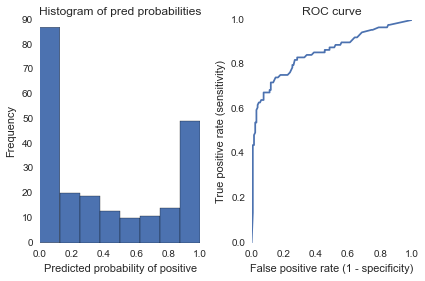

In [25]:
# Retrieve probability metrics
fpr, tpr, thresholds, auc = evaluate_prob(y_test, predict_prob)

In [26]:
# Determine class metrics for new threshold
evaluate_threshold(0.5)

Sensitivity: 0.719101123596
Specificity: 0.865671641791


In [27]:
# Determine class metrics for new threshold
evaluate_threshold(0.25)

Sensitivity: 0.831460674157
Specificity: 0.716417910448


In [38]:
# Change threshold for classification 
# One of the last steps in the model building process
from sklearn.preprocessing import binarize
y_pred_thresh = binarize(predict_prob, 0.3)[0]

C:\Users\Erin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [39]:
acc, conf, sens, spec, prec = evaluation_metrics(y_test, y_pred_thresh)

Null accuracy: 0.614
Accuracy: 0.798
Confusion matrix: actual(0,1) x predicted(0,1)
 [[111  26]
 [ 19  67]]
Sensitivity: when actual is positive, how often predicted positive 0.779
Specificity: when actual is zero, how often predicted zero 0.81
Precision: when predicted is positive, how often actual positive 0.72


# Final step - submission

In [28]:
# Make predictions for test set.
test_pred = grid.predict(test[predictors])

In [29]:
test_predprob = grid.predict_proba(test[predictors])

In [30]:
test_predprob[10:20][:,1]

array([ 0.     ,  0.09   ,  1.     ,  0.2    ,  1.     ,  1.     ,
        0.05325,  0.52   ,  0.91   ,  0.28   ])

In [31]:
test_pred[0:10]

array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0], dtype=int64)

In [32]:
# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": test_pred
    })

# Any files you save will be available in the output tab below
submission.to_csv('submission.csv', index=False)